# DQ project - duplicates & variable for classification

This file is the deliverable for the Data and Information Quality project at Polimi in year 2023

Authors:
- Luca Gerin 10666665
- Claudio Galimberti 10610720


Data quality issues:
- Duplication
- Variable types

ML Task:
- Classification

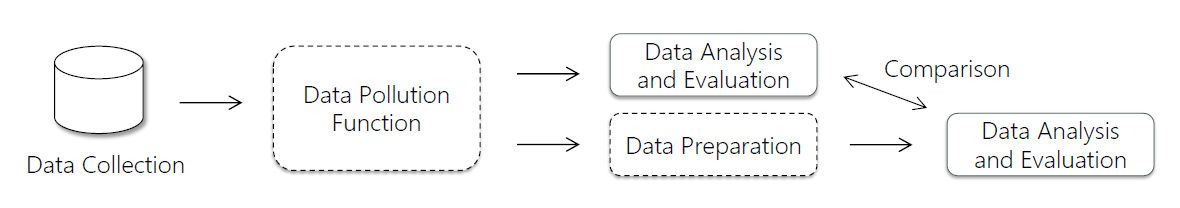

# Script & libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import efficient_apriori
%matplotlib inline

from sklearn.datasets import make_regression, make_classification, make_blobs

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS, Birch
from sklearn import metrics
import time as time
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


# DEFAULT PARAMETERS FOR CLASSIFICATION
#X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

def make_dataset_for_classification(n_samples, n_features, n_informative, n_redundant, n_repeated, n_classes, n_clusters_per_class, weights, flip_y, class_sep, hypercube, seed):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant,
                               n_repeated=n_repeated, n_classes=n_classes, n_clusters_per_class=n_clusters_per_class,
                               weights=weights, flip_y=flip_y, class_sep=class_sep, hypercube=hypercube, random_state=seed)
    return X, y

#N.B. ONLY FOR PROJECTS ON DATA TYPES: USE THIS FUNCTION TO ENCODE CATEGORICAL VARIABLES BEFORE STANDARDIZATION
def encoding_categorical_variables(X):
    def encode(original_dataframe, feature_to_encode):
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], dummy_na=True)
        res = pd.concat([original_dataframe, dummies], axis=1)
        res = res.drop([feature_to_encode], axis=1)
        return (res)

    categorical_columns=list(X.select_dtypes(include=['bool','object']).columns)

    for col in X.columns:
        if col in categorical_columns:
            X = encode(X,col)
    return X

@ignore_warnings(category=ConvergenceWarning)
def classification(X, y, classifier, seed):
    X = StandardScaler().fit_transform(X)
    X = np.nan_to_num(X)
    clf = DecisionTreeClassifier()

    if classifier == "DecisionTree":
        clf = DecisionTreeClassifier()
    elif classifier == "LogisticRegression":
        clf = LogisticRegression()
    elif classifier == "KNN":
        clf = KNeighborsClassifier()
    elif classifier == "RandomForest":
        clf = RandomForestClassifier()
    elif classifier == "AdaBoost":
        clf = AdaBoostClassifier()
    elif classifier == "MLP":
        clf = MLPClassifier()

    print("Training for "+classifier+"...")

    start = time.time()

    model_fit = clf.fit(X, y)

    cv = ShuffleSplit(n_splits=8, test_size=0.3, random_state=seed)

    model_scores = cross_val_score(model_fit, X, y, cv=cv, scoring="f1_weighted")

    stop = time.time()
    speed = stop - start

    f1_mean = model_scores.mean()

    return {"mean_perf": f1_mean,
            "distance": distance_measurement(X, y, classifier, False, seed),
            "speed": speed}

def distance_measurement(X, y, method, regression, seed):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, mean_squared_error

    X = StandardScaler().fit_transform(X)
    X = np.nan_to_num(X)

    N = 8
    distances_train_test = np.zeros(N)
    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed + i)

        model = DecisionTreeClassifier()

        if method == "DecisionTree":
            model = DecisionTreeClassifier()
        elif method == "LogisticRegression":
            model = LogisticRegression()
        elif method == "KNN":
            model = KNeighborsClassifier()
        elif method == "RandomForest":
            model = RandomForestClassifier()
        elif method == "AdaBoost":
            model = AdaBoostClassifier()
        elif method == "MLP":
            model = MLPClassifier()
        elif method == "LinearRegressor":
            model = Ridge()
        elif method == "BayesianRidge":
            model = BayesianRidge()
        elif method == "GPRegressor":
            model = GaussianProcessRegressor()
        elif method == "SVMRegressor":
            model = LinearSVR()
        elif method == "KNNRegressor":
            model = KNeighborsRegressor()
        elif method == "MLPRegressor":
            model = MLPRegressor()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_fit = model.predict(X_train)

        if regression:
            mse_pred = abs(mean_squared_error(y_test, y_pred, squared=False))
            mse_fit = abs(mean_squared_error(y_train, y_fit, squared=False))

            distances_train_test[i] = mse_pred - mse_fit
        else:
            weighted_f1_pred = f1_score(y_test, y_pred, average='weighted')
            weighted_f1_fit = f1_score(y_train, y_fit, average='weighted')

            distances_train_test[i] = weighted_f1_fit - weighted_f1_pred

    return distances_train_test.mean()

C:\Users\Luca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
import matplotlib.pyplot as plt

your_path = "/Users/camillasancricca/Desktop/" # example of path

def mean(results_all):
    list_mean = []
    for res in results_all:
        list_mean.append(res["mean_perf"])
    return list_mean

def distance(results_all):
    list_over = []
    for res in results_all:
        list_over.append(res["distance"])
    return list_over

def speed(results_all):
    list_speed = []
    for res in results_all:
        list_speed.append(res["speed"])
    return list_speed

def generateFigurePerformance(x_axis, xlabel, results_all, title, legend, score):

    plt.title(title)
    for i in range(0,len(results_all)):

        mean_perf = mean(results_all[i])

        plt.plot(x_axis, mean_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    #plt.savefig(your_path + title + ".pdf", bbox_inches='tight') # if you want to save the figure
    plt.show()

def generateFigureDistance(x_axis, xlabel, results_all, title, legend, score):

    plt.title(title)
    for i in range(0,len(results_all)):

        distance_perf = distance(results_all[i])

        plt.plot(x_axis, distance_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2) # if you want to fix a limit for the y_axis
    #plt.savefig(your_path + title + ".pdf", bbox_inches='tight') # if you want to save the figure
    plt.show()

def generateFigureSpeed(x_axis, xlabel, results_all, title, legend, score):

    plt.title(title)
    for i in range(0,len(results_all)):

        speed_perf = speed(results_all[i])

        plt.plot(x_axis, speed_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    #plt.savefig(your_path + title + ".pdf", bbox_inches='tight') # if you want to save the figure
    plt.show()

def plot(x_axis_values, x_label, results, title, algorithms, plot_type):

    title = str(title)

    if plot_type == "performance":
        if algorithms[0] == "DecisionTree":
            generateFigurePerformance(x_axis_values, x_label, results, title, algorithms, "f1 weighted")
        elif algorithms[0] == "LinearRegressor":
            generateFigurePerformance(x_axis_values, x_label, results, title, algorithms, "RMSE")
        else:
            generateFigurePerformance(x_axis_values, x_label, results, title, algorithms, "silhouette")

    elif plot_type == "distance train-test": # only for classification & regression
        if algorithms[0] == "DecisionTree":
            generateFigureDistance(x_axis_values, x_label, results, title, algorithms, "f1_train - f1_test")
        else:
            generateFigureDistance(x_axis_values, x_label, results, title, algorithms, "RMSE_test - RMSE_train")

    else:
        generateFigureSpeed(x_axis_values, x_label, results, title, algorithms, "speed")

# Data exploration

Create and visualize the datasets:

In [2]:
X_test, y_test = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

In [3]:
print(type(X_test))

<class 'numpy.ndarray'>


In [4]:
df = pd.DataFrame(X_test)
print(df.head(30))

           0         1         2         3         4
0  -3.044852  0.401225  1.876653  1.566605 -2.132950
1   1.445783  1.330753  1.140285  0.706253  2.422165
2   2.404213  1.620161 -0.710273 -3.793487  1.183956
3   1.573431 -0.558834  0.359672  0.777892  2.637753
4  -0.849001  2.114740  3.329424 -1.255837 -1.173801
5  -1.752346  0.251198 -2.229832 -0.823034 -1.455396
6   0.414611 -1.407412 -2.849978 -3.032828 -1.189222
7   0.130171 -2.016133 -0.542940 -2.755919  0.404544
8   0.751437  0.446461 -0.084785 -3.234818  1.585166
9  -1.344849  1.833072 -1.957064 -2.240312 -0.860913
10 -1.728696 -0.660541  0.830745 -0.299658  0.769122
11  0.266637  3.411122  0.332535 -0.921959 -0.789412
12 -0.349921 -1.800791 -0.968512 -0.830363  0.675755
13  1.900576  0.118580  0.269640 -0.797242  1.873636
14  0.083724  1.796876 -1.771973 -0.236050 -2.307959
15 -0.455179 -0.652881  1.809340 -2.008444  1.680840
16 -0.878150  0.784111  0.824851 -0.801813 -0.598953
17 -0.472219 -2.393467 -2.068612 -2.415668 -0.

In [5]:
import pandas_profiling

# Assume df is your DataFrame
profile = pandas_profiling.ProfileReport(df)
#profile.to_file("output.html") #DECOMMENT TO GENERATE OUTPUT FILE

C:\Users\Luca\AppData\Local\Temp\ipykernel_17596\1570725491.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# Duplicates - Data pollution

# Duplicates - Data analysis and evaluation

# Duplicates - Data cleaning

# Duplicates - Data analysis and evaluation after cleaning

# Variable types - Data pollution

Correlation analysis: we want to identify relationships between variables using correlation coefficients

In [6]:
df.corr()

,0,1,2,3,4
0,1.000000,0.115730,-0.156550,-0.014878,0.275185
1,0.115730,1.000000,0.219685,0.140620,-0.271040
2,-0.156550,0.219685,1.000000,0.379374,0.135801
3,-0.014878,0.140620,0.379374,1.000000,0.423421
4,0.275185,-0.271040,0.135801,0.423421,1.000000


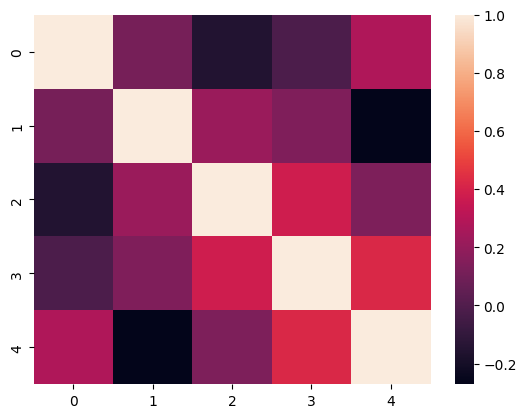

In [7]:
#create heatmap for correlation matrix

#Create variable equal to corr matrix
corr = df.corr(method ='pearson')

#Create heatmap for correlation
sns.heatmap(corr)
plt.show()

To generate new features, we exploit some dependency that we appositely create between the existing features and the newly generated one that we want to be categorical or boolean

In [8]:
from enum import Enum

#enumerate positive or negative numbers
class Sign(Enum):
    POSITIVE = 1
    NEGATIVE = 2

#Enumerate some colors
class Color(Enum):
    GREEN = 1
    BLUE = 2
    PURPLE = 3
    YELLOW = 4
    ORANGE = 5
    RED = 6


#Enumerate the numbers from 1 to 40
class Number(Enum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    ELEVEN = 11
    TWELVE = 12
    THIRTEEN = 13
    FOURTEEN = 14
    FIFTEEN = 15
    SIXTEEN = 16
    SEVENTEEN = 17
    EIGHTEEN = 18
    NINETEEN = 19
    TWENTY = 20
    TWENTYONE = 21
    TWENTYTWO = 22
    TWENTYTHREE = 23
    TWENTYFOUR = 24
    TWENTYFIVE = 25
    TWENTYSIX = 26
    TWENTYSEVEN = 27
    TWENTYEIGHT = 28
    TWENTYNINE = 29
    THIRTY = 30
    THIRTYONE = 31
    THIRTYTWO = 32
    THIRTYTHREE = 33
    THIRTYFOUR = 34
    THIRTYFIVE = 35
    THIRTYSIX = 36
    THIRTYSEVEN = 37
    THIRTYEIGHT = 38
    THIRTYNINE = 39
    FORTY = 40


First added feature: categorical column with two values

In [9]:
#function to create a new column based on the sum of the columns of the dataframe, assigning enum POS or NEG according to sign
def add_sum_POS_NEG(df):
    df['sum_sign'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: Sign.POSITIVE if x > 0 else Sign.NEGATIVE)
    return df

#function to create a new column based on the sum of the columns of the dataframe, assigning TRUE or FALSE according to sign
def add_sum_POS_NEG_bool(df):
    df['sum_sign_positive'] = df.iloc[:, 0:4].sum(axis=1).apply(lambda x: True if x > 0 else False)
    return df


Second added feature: categorical column containing a color based on the value of the median absolute deviation

In [10]:
#funtion to generate a new column with the median absolute deviation of other columns of the dataframe
def add_median_absolute_deviation_column(df):
    df['mad_colors'] = df.iloc[:, 0:4].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    return df


In [11]:
#find the minimum and maximum value in the mad column
#print('min: '+str(df['mad'].min()))
#print('max: '+str(df['mad'].max()))

In [12]:


#replace the 'mad' value with a color according to fixed intervals
def mad_to_color(df):
    df['mad_colors'] = df['mad_colors'].apply(lambda x: Color.GREEN if x < 0.5 else Color.BLUE if x < 1.0 else Color.PURPLE if x < 1.5 else Color.YELLOW if x < 2.0 else Color.ORANGE if x < 2.5 else Color.RED)
    return df



In [13]:
def add_mad_colors(df):
    df = add_median_absolute_deviation_column(df)
    df = mad_to_color(df)
    return df

Third added feature: categorical column containing enumeration of number names, assigned according always to the mad but in a variable number and following equally wide intervals that depend on the specified number of intervals

In [14]:
def add_mad_numbers(df, num_intervals, col_name='mad_num'):

    if( num_intervals > 39): return df

    df[col_name] = df.iloc[:, 0:4].apply(lambda x: abs(x - x.median()).mean(), axis=1)
    max = df[col_name].max()
    min = df[col_name].min()
    interval_wide = (max - min)/num_intervals
    #print('max-min: '+str(df.max()['mad_num'] - df.min()['mad_num']))
    #print('interval_wide: '+str(interval_wide))
    
    # Convert Enum to list
    enum_list = list(Number)
    for i in range(0, num_intervals):
        df[col_name] = df[col_name].apply(lambda x: enum_list[i] if (isinstance(x, float)) and ( min + interval_wide * i <= x < min + interval_wide * (i + 1) ) else x)
    return df
    

#df = add_mad_numbers(df, 10)
#df



Test the functions:

In [15]:
X_test, y_test = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)
df_test = pd.DataFrame(X_test)

add_sum_POS_NEG(df_test)
add_mad_colors(df_test)
add_mad_numbers(df_test, 10)
df_test

,0,1,2,3,4,sum_sign,mad_colors,mad_num
0,-3.044852,0.401225,1.876653,1.566605,-2.132950,Sign.POSITIVE,Color.YELLOW,Number.SIX
1,1.445783,1.330753,1.140285,0.706253,2.422165,Sign.POSITIVE,Color.GREEN,Number.ONE
2,2.404213,1.620161,-0.710273,-3.793487,1.183956,Sign.NEGATIVE,Color.ORANGE,Number.NINE
3,1.573431,-0.558834,0.359672,0.777892,2.637753,Sign.POSITIVE,Color.BLUE,Number.THREE
4,-0.849001,2.114740,3.329424,-1.255837,-1.173801,Sign.POSITIVE,Color.YELLOW,Number.EIGHT
...,...,...,...,...,...,...,...,...
995,0.852847,-0.726076,-2.160768,-3.265680,-0.749785,Sign.NEGATIVE,Color.PURPLE,Number.SIX
996,0.482150,0.830578,0.418977,1.189807,2.350933,Sign.POSITIVE,Color.GREEN,Number.ONE
997,0.173973,-1.095862,0.148571,-1.312195,1.049151,Sign.NEGATIVE,Color.BLUE,Number.THREE
998,-1.475855,-0.718746,-2.108539,-1.984390,-2.674930,Sign.NEGATIVE,Color.GREEN,Number.TWO


Briefly study the added columns:

In [16]:
#count the occurences of POSITIVE and NEGATIVE
df_test['sum_sign'].value_counts()

sum_sign
Sign.NEGATIVE    542
Sign.POSITIVE    458
Name: count, dtype: int64

<Axes: xlabel='sum_sign'>

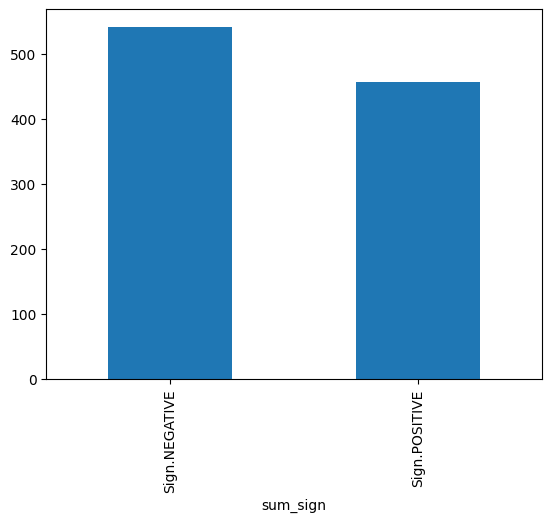

In [17]:
#print a histogram of the value counts in 'sum_sign' column
df_test['sum_sign'].value_counts().plot(kind='bar')

In [18]:
#count the occurences of the mad colors
df_test['mad_colors'].value_counts()

mad_colors
Color.BLUE      431
Color.PURPLE    332
Color.YELLOW    120
Color.GREEN      92
Color.ORANGE     24
Color.RED         1
Name: count, dtype: int64

<Axes: xlabel='mad_colors'>

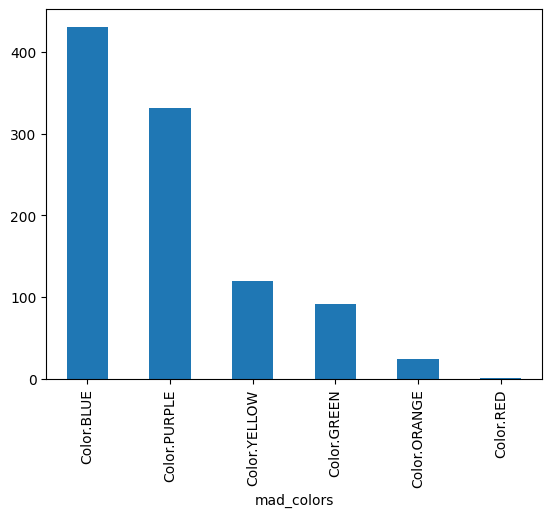

In [19]:
#print a histogram of the value counts in 'mad_colors' column
df_test['mad_colors'].value_counts().plot(kind='bar')

In [20]:
#count the occurences of the mad numbers
df_test['mad_num'].value_counts()

mad_num
Number.FOUR     230
Number.THREE    218
Number.FIVE     162
Number.TWO      138
Number.SIX      107
Number.SEVEN     58
Number.ONE       43
Number.EIGHT     30
Number.NINE      10
Number.TEN        4
Name: count, dtype: int64

<Axes: xlabel='mad_num'>

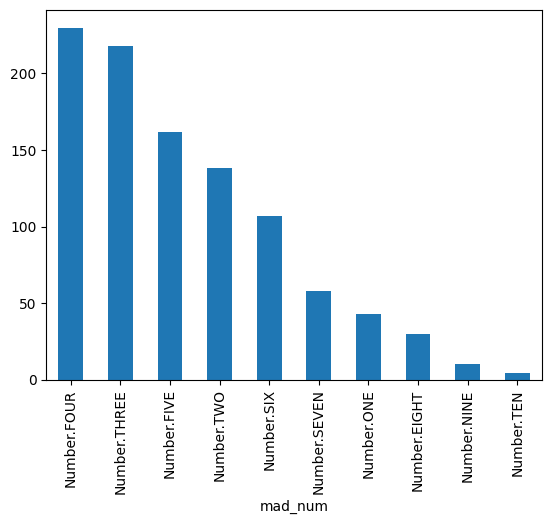

In [21]:
#print a histogram of the value counts in 'mad_num' column
df_test['mad_num'].value_counts().plot(kind='bar')

Generate datasets for 10 different experiments:

In [22]:
X_vt = []
df_vt = []
y_vt = []

#generate 10 random non-repeated integer seeds
seeds = np.random.choice(10000, 10, replace=False)

#generate 10 datasets for the experiments
for i in range (0,10):
    X_temp, y_temp = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=seeds[i])
    X_vt.append(X_temp)
    df_vt.append(pd.DataFrame(X_temp))
    y_vt.append(y_temp)

    #df_temp = pd.DataFrame(X_vt[i])
    #print(df_temp.head(3))

Pollute the 10 experiments with categorical columns in different measures

In [23]:
for i, df in enumerate(df_vt):
    if i == 0:
        #Ex1: boolean col
        add_sum_POS_NEG_bool(df)
    elif i == 1:
        #Ex2: colors
        add_mad_colors(df)
    elif i == 2:
        #Ex3: numbers 10
        add_mad_numbers(df, 10)
    elif i == 3:
        #Ex4: numbers 30
        add_mad_numbers(df, 30)
    elif i == 4:
        #Ex5: boolean col + sign string
        add_sum_POS_NEG_bool(df)
        add_sum_POS_NEG(df)
    elif i == 5:
        #Ex6: boolean col + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_numbers(df, 10)
    elif i == 6:
        #Ex7: colors + numbers 10
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 7:
        #Ex8: colors + numbers 30
        add_mad_colors(df)
        add_mad_numbers(df, 30)
    elif i == 8:
        #Ex9: boolean col + colors + numbers 10
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
    elif i == 9:
        #Ex10: boolean col + colors + numbers 10 + numbers 30
        add_sum_POS_NEG_bool(df)
        add_mad_colors(df)
        add_mad_numbers(df, 10)
        add_mad_numbers(df, 30, "mad_num_2")
    else:
        print("error in pollution")

In [24]:
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4  sum_sign_positive
0  0.550137 -1.627865 -0.410032  0.632005  2.009135              False
1  1.035566 -1.733071  1.566978  1.385013  0.531731               True
2 -0.900463 -0.995746 -0.703362  1.069361  0.479786              False

dataset 1:
          0         1         2         3         4    mad_colors
0  0.097583  0.889880 -1.424302  2.053594  0.861671  Color.PURPLE
1  0.277904  0.309067  1.247006  0.021864 -1.449396   Color.GREEN
2  0.609909 -0.102475 -1.010620 -0.196065  1.781709   Color.GREEN

dataset 2:
          0         1         2         3         4      mad_num
0 -0.787611  0.882880 -0.144980 -0.123302  1.703616   Number.TWO
1 -0.113451  2.182667 -2.159141  0.658340  2.060505  Number.FIVE
2 -1.585468  0.700939 -0.755450  1.151351  1.729240  Number.FOUR

dataset 3:
          0         1         2         3         4           mad_num
0 -1.821425  1.297630  1.262340 -3.165276  0.904479  Number.SEVENTEEN
1 -0

# Variable types - data anlysis and evaluation

ML algorithms require numerical input, so we firstly encode categorical variables to convert qualitative attributes into numerical values.

In [25]:
for i in range(0,10):
    df_vt[i] = encoding_categorical_variables(df_vt[i])

In [26]:
for i, df in enumerate(df_vt):
    print('\ndataset '+str(i)+":")
    print(df.head(3))


dataset 0:
          0         1         2         3         4
0  0.550137 -1.627865 -0.410032  0.632005  2.009135
1  1.035566 -1.733071  1.566978  1.385013  0.531731
2 -0.900463 -0.995746 -0.703362  1.069361  0.479786

dataset 1:
          0         1         2         3         4  mad_colors_Color.PURPLE  \
0  0.097583  0.889880 -1.424302  2.053594  0.861671                     True   
1  0.277904  0.309067  1.247006  0.021864 -1.449396                    False   
2  0.609909 -0.102475 -1.010620 -0.196065  1.781709                    False   

   mad_colors_Color.GREEN  mad_colors_Color.BLUE  mad_colors_Color.ORANGE  \
0                   False                  False                    False   
1                    True                  False                    False   
2                    True                  False                    False   

   mad_colors_Color.YELLOW  mad_colors_Color.RED  mad_colors_nan  
0                    False                 False           False  
1   

In [27]:
#convert dataframe back to numpy.ndarray
X_vt_polluted = [df.to_numpy() for df in df_vt]

In [28]:
#print X_vt
print(X_vt_polluted[0])

[[ 0.55013705 -1.62786485 -0.41003213  0.63200463  2.00913529]
 [ 1.03556611 -1.73307111  1.56697804  1.38501281  0.53173063]
 [-0.9004632  -0.99574562 -0.70336212  1.06936137  0.47978568]
 ...
 [-1.09853236  0.09612479 -1.63767225 -0.46101638  0.37745335]
 [ 1.43893118 -0.17826819  0.27548146  1.95780973  0.92795204]
 [-1.76781258  1.02843476 -0.20146383  1.04803733  4.10330182]]


Actual results collection:

In [31]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

results_for_each_algorithm = []
SEED = 2023

for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []
    for i in range(0, 10):
        results_1_analysis = classification(X_vt_polluted[i], y_vt[i], algorithm, SEED)
        results_single_algorithm.append(results_1_analysis)
    results_for_each_algorithm.append(results_single_algorithm)

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

In [32]:
print(results_for_each_algorithm)

[[{'mean_perf': 0.8941767794040025, 'distance': 0.10877916308493454, 'speed': 0.10471916198730469}, {'mean_perf': 0.8561788021108283, 'distance': 0.14382845913716363, 'speed': 0.08577156066894531}, {'mean_perf': 0.844911600029848, 'distance': 0.14547604019390145, 'speed': 0.07679438591003418}, {'mean_perf': 0.8469136909692873, 'distance': 0.14463072519135012, 'speed': 0.09474468231201172}, {'mean_perf': 0.9216700129948995, 'distance': 0.08627585786909155, 'speed': 0.06758975982666016}, {'mean_perf': 0.7878615350686574, 'distance': 0.19995353389801365, 'speed': 0.0857701301574707}, {'mean_perf': 0.8429048344041713, 'distance': 0.16119861975100014, 'speed': 0.0827789306640625}, {'mean_perf': 0.9070885949300966, 'distance': 0.09332018541003531, 'speed': 0.07579588890075684}, {'mean_perf': 0.8786806299354483, 'distance': 0.1274897995019611, 'speed': 0.08374500274658203}, {'mean_perf': 0.8457721472979958, 'distance': 0.15041341320560417, 'speed': 0.09973740577697754}], [{'mean_perf': 0.9016

In [33]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_for_each_algorithm)

[   [   {   'distance': 0.10877916308493454,
            'mean_perf': 0.8941767794040025,
            'speed': 0.10471916198730469},
        {   'distance': 0.14382845913716363,
            'mean_perf': 0.8561788021108283,
            'speed': 0.08577156066894531},
        {   'distance': 0.14547604019390145,
            'mean_perf': 0.844911600029848,
            'speed': 0.07679438591003418},
        {   'distance': 0.14463072519135012,
            'mean_perf': 0.8469136909692873,
            'speed': 0.09474468231201172},
        {   'distance': 0.08627585786909155,
            'mean_perf': 0.9216700129948995,
            'speed': 0.06758975982666016},
        {   'distance': 0.19995353389801365,
            'mean_perf': 0.7878615350686574,
            'speed': 0.0857701301574707},
        {   'distance': 0.16119861975100014,
            'mean_perf': 0.8429048344041713,
            'speed': 0.0827789306640625},
        {   'distance': 0.09332018541003531,
            'mean_perf': 0.

PLOT THE RESULTS:

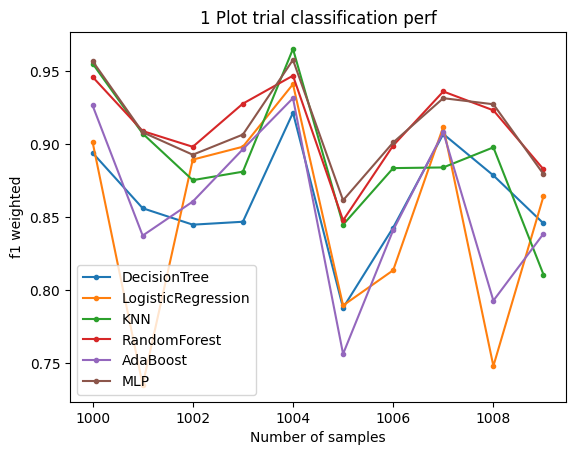

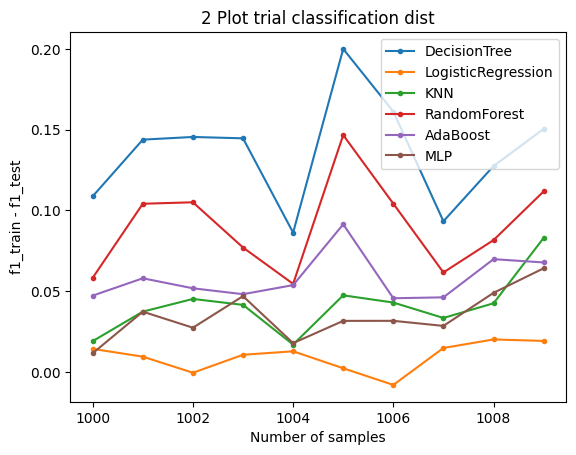

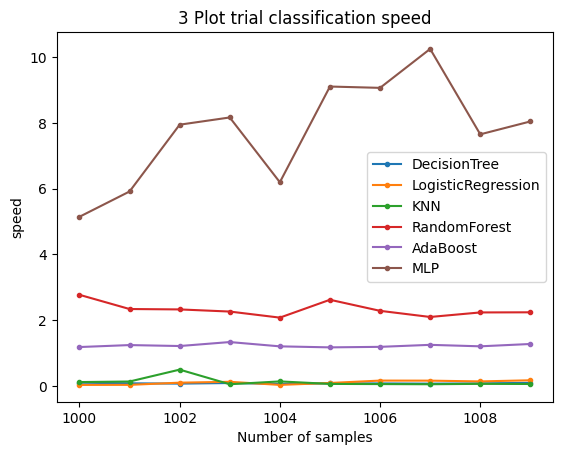

In [36]:
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="1 Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="2 Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1000,1001,1002,1003,1004,1005,1006,1007,1008,1009], x_label="Number of samples", results=results_for_each_algorithm, title="3 Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")